### Methods & Settings

In [1]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=false; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">HIDE/SHOW CONTENT</a>.''')
display(tag)

############### Write code below ##################

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import gc
import joblib
import math

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:75% !important; }</style>"))

pd.set_option('display.max_rows', 250)
pd.set_option('display.min_rows', 25)
pd.set_option('display.max_columns', 50)

####
# prints memory usage
def show_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB\n'.format(start_mem))
    return

####
# seperates features from label (y must be last column)
def sep_X_y(df):
    X = df.iloc[:,0:-1] # extracts all rows [:] and columns from 0 to next-to-last [0:-1]
    y = df.iloc[:,-1] # extracts all rows [:] and only last column [-1]
    
    return [X, y]

####
# split training and test set from given dataframe with month as boundaries
def mth_train_test_split(df, mth_start, mth_end):
    print('Splitting dataframe...\n')
    
    # get indices from desired boundaries
    idx_start = df.month.searchsorted(mth_start_train, side='left') # list needs to be sorted already for searchsorted
    idx_end = df.month.searchsorted(mth_end_train + 1, side='left')
    
    df = df.iloc[idx_start:idx_end]
    
    return df

####
# trains XGB model (regressor)
def train_xgb(X, y):
    
    print('Fitting model...\n')
    model = XGBRegressor(tree_method='gpu_hist', gpu_id=0)
    fitted_model = model.fit(X, y)
    
    #print('Plotting feature importance for "gain". Do not rely on that.\n')
    print('https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27\n')
    xgb.plot_importance(model, importance_type='gain', max_num_features=25)
    plt.show()
    
    # GRAPHVIZ (software + pip package) needed for tree plotting
    #fig, ax = plt.subplots(figsize=(30, 30))
    #xgb.plot_tree(model, num_trees=0, ax=ax, rankdir='LR')
    #plt.show()
    
    return fitted_model

####
# trains LinearRegression model
def train_linReg(X, y):
    
    print('Fitting model...\n')
    model = LinearRegression()
    fitted_model = model.fit(X, y)
    
    #print('Plotting feature importance for "gain". Do not rely on that.\n')
#    print('https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27\n')
#     xgb.plot_importance(model, importance_type='gain', max_num_features=25)
#     plt.show()
    
    # GRAPHVIZ (software + pip package) needed for tree plotting
    #fig, ax = plt.subplots(figsize=(30, 30))
    #xgb.plot_tree(model, num_trees=0, ax=ax, rankdir='LR')
    #plt.show()
    
    return fitted_model

####
# trains XGB model (regressor)
def train_lgbm(X, y):
    
    print('Fitting model...\n')
    model = LGBMRegressor(boosting_type='gbdt', device="gpu")
    fitted_model = model.fit(X, y)
    
    print('Plotting feature importance for "gain".')
    print('https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27\n')
    lgb.plot_importance(model, importance_type='gain', max_num_features=25)
    plt.show()
    
    # GRAPHVIZ (software + pip package) needed for tree plotting
    #fig, ax = plt.subplots(figsize=(30, 30))
    #xgb.plot_tree(model, num_trees=0, ax=ax, rankdir='LR')
    #plt.show()
    
    return fitted_model


def train_xgb_bestHyper(X, y):
    X_train = X
    y_train = y
    space = best_hyperparams
    
    print('Fitting model...\n')
    model = XGBRegressor(tree_method='gpu_hist', gpu_id=0,
                    eta = space['eta'],
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))

    
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    fitted_model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    
    print('Plotting feature importance for "gain". Do not rely on that.\n')
    print('https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27\n')
    xgb.plot_importance(model, importance_type='gain')
    plt.show()
    
    # GRAPHVIZ (software + pip package) needed for tree plotting
    #fig, ax = plt.subplots(figsize=(30, 30))
    #xgb.plot_tree(model, num_trees=0, ax=ax, rankdir='LR')
    #plt.show()
    
    return fitted_model

def train_dtc(X, y):
    X_train = X
    y_train = y
    
    print('Fitting model...\n')
    model = DecisionTreeRegressor()
    fitted_model = model.fit(X_train, y_train)
    
    #print('Plotting feature importance for "gain". Do not rely on that.\n')
    print('https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27\n')
    #xgb.plot_importance(model, importance_type='gain')
    #plt.show()
    
    # GRAPHVIZ (software + pip package) needed for tree plotting
    #fig, ax = plt.subplots(figsize=(30, 30))
    #xgb.plot_tree(model, num_trees=0, ax=ax, rankdir='LR')
    #plt.show()
    
    return fitted_model

####
# predicts labels of training and test with given model
def predict_values(model, X, y_true):
    print('Predicting values...\n')
    # predict y values
    y_pred = model.predict(X)
    
    # get msq
    model_error = mean_squared_error(y_true, y_pred)
    
    # print info about accuracies
    print(f'\t\t\t\t\t\033[1m XGboost Regressor MSE: '
          f'\033[4m\033[1m {model_error:.3f}\n')
    
    print(f'\t\t\t\t\t\033[1m XGboost Regressor RMSE: '
          f'\033[4m\033[1m {math.sqrt(model_error):.3f}')
    
    # return predicted values
    return y_pred

####
# concatenates prediction with actual target for evaluation
def concat_ytrue_ypred(X, y_true, y_pred):
    # create dataframe from test-prediction with index from X_test
    df_y_pred = pd.DataFrame(y_pred, columns=['nextBuyIn_pred'], index=X.index, dtype=np.int8)

    # concatenate X, y, y_pred (put columns next to each other)
    df_eval = pd.concat([X, y_true, df_y_pred], axis=1)
    
    return df_eval

####
# executes all needed functions of the above with given training and test data and provided train method
# def execute_pipeline(train_method, df, start_mth, end_mth):
#     b = list_of_four_df_boundaries
#     # split dataframe in train/test and X/y
#     X_train, y_train, X_test, y_test = dt_train_test_split(df, b[0], b[1], b[2], b[3])
    
#     #train model
#     model = train_method(X_train, y_train)    
    
#     # make predictions
#     pred_train, pred_test = predict_values(model, X_train, y_train, X_test, y_test)
    
#     print('\nExecuted pipeline.\nEvaluate with "evaluate_pred(X, y, y_pred)"\n')
#     return [pred_train, pred_test, X_train, y_train, X_test, y_test]

# <font color='purple'>Predicting Weeks w/o normalization + categories multihot (Train/Test)</color>


In [2]:
train = r'C:\Users\LEAND\Coding\Jupyter Notebooks\csv\17-1_220624_4TimeRepurchaser_train.csv'
test = r'C:\Users\LEAND\Coding\Jupyter Notebooks\csv\17-2_220624_4TimeRepurchaser_test.csv'

columns = [#'date',
           'userID', 
           'itemID',
           'order', 
           'brand', 
           'feature_1', 
           'feature_2', 
           'feature_3', 
           'feature_4', 
           'feature_5',
           'categories',
           'brandOrderRatio',
           'feature1OrderRatio',
           'feature2OrderRatio',
           'feature3OrderRatio',
           'feature4OrderRatio',
           'feature5OrderRatio',
           'TotalBFscore',
           'RCP',
           'MeanDiffToNxt(user)',
           'TotalItemOrders(user)',
           #'TotalItemOrders(item)',
           'date(year)',
           'date(month)',
           'date(weekOfMonth)',
           'date(dayOfMonth)',
           'date(weekOfYear)',
           'date(dayOfYear)',
           #'nextBuyInWeeks(round)', # label
           'nextBuyInWeeks(floor)', # label
           #'nextBuyInWeekOfYear' # label; schlechte idee
          ]

dtype = {'userID':np.uint16,
         'itemID':np.uint16,
         'order':np.uint8,
         'brand':np.int16,
         'feature_1':np.int8,
         'feature_2':np.uint8,
         'feature_3':np.int16,
         'feature_4':np.int8,
         'feature_5':np.int16,
         'TotalItemOrders(user)':np.uint16,
         'date(year)':np.uint16,
         'date(month)':np.uint8,
         'date(weekOfMonth)':np.uint8,
         'date(dayOfMonth)':np.uint8,
         'date(weekOfYear)':np.uint8,
         'date(dayOfYear)':np.uint8,
         'nextBuyInWeeks(floor)':np.uint8
        }

label = 'nextBuyInWeeks(floor)'

## Preparation

In [5]:
df_train = pd.read_csv(train, sep='|', usecols=columns, dtype=dtype, nrows=None, converters={
    'categories': lambda x: [int(i) for i in x[1:-1].split(',')]
})

df_test = pd.read_csv(test, sep='|', usecols=columns, dtype=dtype, nrows=None, converters={
    'categories': lambda x: [int(i) for i in x[1:-1].split(',')]
})

# add fake column for ensuring all categories from 0 to 4299 are included
df_train.loc[len(df_train)] = [0 if column != 'categories' else [cat for cat in range(0,4300)] for column in df_train.columns]
df_train.index = df_train.index + 1  # add index

df_test.loc[len(df_test)] = [0 if column != 'categories' else [cat for cat in range(0,4300)] for column in df_test.columns]
df_test.index = df_test.index + 1  # add index

df = df_train

In [6]:
# multi-hot-encode categories
cats = df["categories"]
mlb = MultiLabelBinarizer(sparse_output=False) # Set to True if output binary array is desired in CSR sparse format
df_multi_hot = pd.DataFrame(mlb.fit_transform(cats), columns=mlb.classes_, index=df.index, dtype=np.int8).astype(pd.SparseDtype(np.uint8,0)) # NaN filled with 0

# drop fake rows from both dataframes (last row) & drop category '9999' standing for missing category
df_multi_hot.drop(index=df.index[-1], axis=0, inplace=True)
df_multi_hot = df_multi_hot.iloc[:,:-1]
df.drop(index=df.index[-1], axis=0, inplace=True)

# join new binarized columns with rest of dataframe
df = df.join(df_multi_hot, how='inner')

if (len(df[df.isnull().any(axis=1)]) > 0):
    raise RuntimeError('Join of multi-hot-encoded categories probably created missing values.')

# drop list of categories, since it's not needed anymore
df.drop('categories', axis=1, inplace=True)

# pop and append 'week' at end of dataframe
col = df.pop(label)
df.insert(len(df.columns), col.name, col)

del df_multi_hot
gc.collect()

df

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),...,4276,4277,4278,4279,4280,4281,4282,4283,4284,4285,4286,4287,4288,4289,4290,4291,4292,4293,4294,4295,4296,4297,4298,4299,nextBuyInWeeks(floor)
1,276,15667,1,1201,4,0,30,0,163,0.000659,0.023826,0.044684,0.000067,0.033429,0.000773,0.911912,1.0,4,44.500000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
2,276,28708,1,504,10,0,441,3,84,0.000978,0.020648,0.044684,0.001161,0.016194,0.004704,0.775920,1.0,3,37.000000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
3,532,7644,1,1276,6,0,45,3,48,0.000081,0.005880,0.044684,0.000031,0.016194,0.000575,0.587077,1.0,3,52.500000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10
4,752,22963,1,1201,10,0,43,0,147,0.000659,0.020648,0.044684,0.000451,0.033429,0.000283,0.882270,1.0,7,47.333333,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
5,1123,18498,1,1401,4,0,95,0,44,0.000074,0.023826,0.044684,0.000017,0.033429,0.003489,0.930692,1.0,2,62.000000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39732,8786,14420,1,703,4,0,335,0,132,0.001555,0.023826,0.044684,0.001050,0.033429,0.000772,0.928863,1.0,3,7.000000,2021,1,2,16,2,16,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39733,19221,8927,2,745,10,0,503,0,85,0.000519,0.020648,0.044684,0.002691,0.033429,0.000552,0.903662,1.0,6,78.500000,2021,1,2,17,2,17,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39734,34638,4935,1,1127,4,0,360,3,144,0.000231,0.023826,0.044684,0.000084,0.016194,0.004163,0.783249,1.0,27,8.538462,2021,1,2,17,2,17,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39735,21517,594,1,203,4,1,491,0,66,0.000049,0.023826,0.003734,0.001981,0.033429,0.001987,0.565054,1.0,4,41.000000,2021,1,3,20,3,20,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# save column names
column_headers = list(df.columns)

In [8]:
# split DF in X & y
X_train, y_train = sep_X_y(df)
X_train

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),...,4275,4276,4277,4278,4279,4280,4281,4282,4283,4284,4285,4286,4287,4288,4289,4290,4291,4292,4293,4294,4295,4296,4297,4298,4299
1,276,15667,1,1201,4,0,30,0,163,0.000659,0.023826,0.044684,0.000067,0.033429,0.000773,0.911912,1.0,4,44.500000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,276,28708,1,504,10,0,441,3,84,0.000978,0.020648,0.044684,0.001161,0.016194,0.004704,0.775920,1.0,3,37.000000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,532,7644,1,1276,6,0,45,3,48,0.000081,0.005880,0.044684,0.000031,0.016194,0.000575,0.587077,1.0,3,52.500000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,752,22963,1,1201,10,0,43,0,147,0.000659,0.020648,0.044684,0.000451,0.033429,0.000283,0.882270,1.0,7,47.333333,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1123,18498,1,1401,4,0,95,0,44,0.000074,0.023826,0.044684,0.000017,0.033429,0.003489,0.930692,1.0,2,62.000000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39732,8786,14420,1,703,4,0,335,0,132,0.001555,0.023826,0.044684,0.001050,0.033429,0.000772,0.928863,1.0,3,7.000000,2021,1,2,16,2,16,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39733,19221,8927,2,745,10,0,503,0,85,0.000519,0.020648,0.044684,0.002691,0.033429,0.000552,0.903662,1.0,6,78.500000,2021,1,2,17,2,17,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39734,34638,4935,1,1127,4,0,360,3,144,0.000231,0.023826,0.044684,0.000084,0.016194,0.004163,0.783249,1.0,27,8.538462,2021,1,2,17,2,17,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39735,21517,594,1,203,4,1,491,0,66,0.000049,0.023826,0.003734,0.001981,0.033429,0.001987,0.565054,1.0,4,41.000000,2021,1,3,20,3,20,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Training & Prediction

## XGBoost Regressor

Pipeline needs training method, dataframe and dates to split dataframe in training and test set.

Fitting model...

https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27



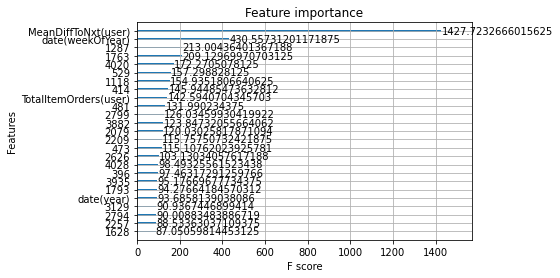

In [9]:
model = train_xgb(X_train, y_train)
#model = train_dtc(X_train, y_train)

In [10]:
y_pred = predict_values(model, X_train, y_train)

Predicting values...

					 XGboost Regressor MSE:  5.256

					 XGboost Regressor RMSE:  2.293


### Evaluation

In [11]:
dtype_X = {'userID':np.uint16,
         'itemID':np.uint16,
         'order':np.uint8,
         'brand':np.int16,
         'feature_1':np.int8,
         'feature_2':np.uint8,
         'feature_3':np.int16,
         'feature_4':np.int8,
         'feature_5':np.int16,
         'TotalItemOrders(user)':np.uint16,
         'date(year)':np.uint16,
         'date(month)':np.uint8,
         'date(weekOfMonth)':np.uint8,
         'date(dayOfMonth)':np.uint8,
         'date(weekOfYear)':np.uint8,
         'date(dayOfYear)':np.uint8
        }
dtype_y = {'nextBuyInWeeks(floor)':np.uint8}

y_pred = pd.DataFrame(y_pred, index=y_train.index).apply(lambda x: round(x)).astype(np.uint8)

y_pred.set_axis(['nextBuyIn_pred'], axis=1,inplace=True)

In [12]:
# concatenate X, y, y_pred (columns next to each other)
df_eval = pd.concat([X_train, y_train, y_pred], axis=1)
df_eval

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),...,4277,4278,4279,4280,4281,4282,4283,4284,4285,4286,4287,4288,4289,4290,4291,4292,4293,4294,4295,4296,4297,4298,4299,nextBuyInWeeks(floor),nextBuyIn_pred
1,276,15667,1,1201,4,0,30,0,163,0.000659,0.023826,0.044684,0.000067,0.033429,0.000773,0.911912,1.0,4,44.500000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,6
2,276,28708,1,504,10,0,441,3,84,0.000978,0.020648,0.044684,0.001161,0.016194,0.004704,0.775920,1.0,3,37.000000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5
3,532,7644,1,1276,6,0,45,3,48,0.000081,0.005880,0.044684,0.000031,0.016194,0.000575,0.587077,1.0,3,52.500000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,7
4,752,22963,1,1201,10,0,43,0,147,0.000659,0.020648,0.044684,0.000451,0.033429,0.000283,0.882270,1.0,7,47.333333,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,6
5,1123,18498,1,1401,4,0,95,0,44,0.000074,0.023826,0.044684,0.000017,0.033429,0.003489,0.930692,1.0,2,62.000000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39732,8786,14420,1,703,4,0,335,0,132,0.001555,0.023826,0.044684,0.001050,0.033429,0.000772,0.928863,1.0,3,7.000000,2021,1,2,16,2,16,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39733,19221,8927,2,745,10,0,503,0,85,0.000519,0.020648,0.044684,0.002691,0.033429,0.000552,0.903662,1.0,6,78.500000,2021,1,2,17,2,17,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
39734,34638,4935,1,1127,4,0,360,3,144,0.000231,0.023826,0.044684,0.000084,0.016194,0.004163,0.783249,1.0,27,8.538462,2021,1,2,17,2,17,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39735,21517,594,1,203,4,1,491,0,66,0.000049,0.023826,0.003734,0.001981,0.033429,0.001987,0.565054,1.0,4,41.000000,2021,1,3,20,3,20,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
rowcount = len(df_eval)
should = rowcount
is_ = len(df_eval.loc[(df_eval['nextBuyInWeeks(floor)'] == df_eval.nextBuyIn_pred)]) 

print(f'\033[1mrow count of set:\t\t\t\t {rowcount}')
print(f'\033[1mrows where label was predicted correctly:\t {is_} \t ({is_/should*100:.3f} % of rows)')

row count of set:				 39736
rows where label was predicted correctly:	 11218 	 (28.231 % of rows)


In [14]:
# multi-hot-encode categories
cats = df_test["categories"]
mlb = MultiLabelBinarizer(sparse_output=False) # Set to True if output binary array is desired in CSR sparse format
df_multi_hot = pd.DataFrame(mlb.fit_transform(cats), columns=mlb.classes_, index=df_test.index, dtype=np.int8).astype(pd.SparseDtype(np.uint8,0)) # NaN filled with 0

# drop fake rows from both dataframes (last row) & drop category '9999' standing for missing category
df_multi_hot.drop(index=df_test.index[-1], axis=0, inplace=True)
df_multi_hot = df_multi_hot.iloc[:,:-1]
df_test.drop(index=df_test.index[-1], axis=0, inplace=True)

# join new binarized columns with rest of dataframe
df_test = df_test.join(df_multi_hot, how='inner')

if (len(df_test[df_test.isnull().any(axis=1)]) > 0):
    raise RuntimeError('Join of multi-hot-encoded categories probably created missing values.')

# drop list of categories, since it's not needed anymore
df_test.drop('categories', axis=1, inplace=True)

# pop and append 'week' at end of dataframe
col = df_test.pop(label)
df_test.insert(len(df_test.columns), col.name, col)

del df_multi_hot
gc.collect()

df_test

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),...,4276,4277,4278,4279,4280,4281,4282,4283,4284,4285,4286,4287,4288,4289,4290,4291,4292,4293,4294,4295,4296,4297,4298,4299,nextBuyInWeeks(floor)
1,21340,16599,1,888,10,0,224,3,132,0.000575,0.027466,0.059594,0.000211,0.021632,0.001015,0.727041,1.0,4,7.500000,2020,6,3,16,25,168,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,19669,19043,1,186,10,3,27,3,39,0.002310,0.027466,0.002299,0.000486,0.021632,0.000971,0.351915,1.0,3,10.000000,2020,6,4,22,26,174,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
3,5218,6168,3,1445,10,0,-1,-1,178,0.000853,0.027466,0.059594,0.000000,0.000000,0.000148,0.574956,1.0,7,10.000000,2020,6,4,26,26,178,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,6042,5423,8,449,4,0,535,3,105,0.000425,0.031841,0.059594,0.000335,0.021632,0.000401,0.752364,1.0,22,7.500000,2020,6,5,29,27,181,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,22362,6657,1,504,10,0,441,3,84,0.001255,0.027466,0.059594,0.001475,0.021632,0.006202,0.775391,1.0,3,14.000000,2020,6,5,30,27,182,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13587,44294,3857,1,724,10,1,503,3,17,0.000029,0.027466,0.005013,0.003676,0.021632,0.004035,0.397249,1.0,5,62.000000,2021,1,4,25,4,25,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13588,44294,5438,1,724,10,1,503,3,-1,0.000029,0.027466,0.005013,0.003676,0.021632,0.000000,0.369892,1.0,3,62.500000,2021,1,4,25,4,25,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13589,10961,27635,3,1006,4,2,487,3,81,0.000143,0.031841,0.000663,0.001529,0.021632,0.001088,0.363654,1.0,12,73.333333,2021,1,4,26,4,26,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13590,23101,1340,1,194,10,0,509,0,39,0.000603,0.027466,0.059594,0.000237,0.044612,0.000971,0.882911,1.0,4,102.500000,2021,1,4,26,4,26,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
X_test, y_test = sep_X_y(df_test)

In [16]:
y_pred = predict_values(model, X_test, y_test)

Predicting values...

					 XGboost Regressor MSE:  16.759

					 XGboost Regressor RMSE:  4.094


In [17]:
dtype_X = {'userID':np.uint16,
         'itemID':np.uint16,
         'order':np.uint8,
         'brand':np.int16,
         'feature_1':np.int8,
         'feature_2':np.uint8,
         'feature_3':np.int16,
         'feature_4':np.int8,
         'feature_5':np.int16,
         'TotalItemOrders(user)':np.uint16,
         'date(year)':np.uint16,
         'date(month)':np.uint8,
         'date(weekOfMonth)':np.uint8,
         'date(dayOfMonth)':np.uint8,
         'date(weekOfYear)':np.uint8,
         'date(dayOfYear)':np.uint8
        }
dtype_y = {'nextBuyInWeeks(floor)':np.uint8}

y_pred = pd.DataFrame(y_pred, index=y_test.index).apply(lambda x: round(x)).astype(np.uint8)

y_pred.set_axis(['nextBuyIn_pred'], axis=1,inplace=True)

In [18]:
# concatenate X, y, y_pred (columns next to each other)
df_eval = pd.concat([X_test, y_test, y_pred], axis=1)
df_eval

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),...,4277,4278,4279,4280,4281,4282,4283,4284,4285,4286,4287,4288,4289,4290,4291,4292,4293,4294,4295,4296,4297,4298,4299,nextBuyInWeeks(floor),nextBuyIn_pred
1,21340,16599,1,888,10,0,224,3,132,0.000575,0.027466,0.059594,0.000211,0.021632,0.001015,0.727041,1.0,4,7.500000,2020,6,3,16,25,168,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
2,19669,19043,1,186,10,3,27,3,39,0.002310,0.027466,0.002299,0.000486,0.021632,0.000971,0.351915,1.0,3,10.000000,2020,6,4,22,26,174,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2
3,5218,6168,3,1445,10,0,-1,-1,178,0.000853,0.027466,0.059594,0.000000,0.000000,0.000148,0.574956,1.0,7,10.000000,2020,6,4,26,26,178,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4
4,6042,5423,8,449,4,0,535,3,105,0.000425,0.031841,0.059594,0.000335,0.021632,0.000401,0.752364,1.0,22,7.500000,2020,6,5,29,27,181,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
5,22362,6657,1,504,10,0,441,3,84,0.001255,0.027466,0.059594,0.001475,0.021632,0.006202,0.775391,1.0,3,14.000000,2020,6,5,30,27,182,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13587,44294,3857,1,724,10,1,503,3,17,0.000029,0.027466,0.005013,0.003676,0.021632,0.004035,0.397249,1.0,5,62.000000,2021,1,4,25,4,25,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
13588,44294,5438,1,724,10,1,503,3,-1,0.000029,0.027466,0.005013,0.003676,0.021632,0.000000,0.369892,1.0,3,62.500000,2021,1,4,25,4,25,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
13589,10961,27635,3,1006,4,2,487,3,81,0.000143,0.031841,0.000663,0.001529,0.021632,0.001088,0.363654,1.0,12,73.333333,2021,1,4,26,4,26,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
13590,23101,1340,1,194,10,0,509,0,39,0.000603,0.027466,0.059594,0.000237,0.044612,0.000971,0.882911,1.0,4,102.500000,2021,1,4,26,4,26,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [19]:
rowcount = len(df_eval)
should = rowcount
is_ = len(df_eval.loc[(df_eval['nextBuyInWeeks(floor)'] == df_eval.nextBuyIn_pred)]) 

print(f'\033[1mrow count of set:\t\t\t\t {rowcount}')
print(f'\033[1mrows where label was predicted correctly:\t {is_} \t ({is_/should*100:.3f} % of rows)')

row count of set:				 13591
rows where label was predicted correctly:	 1492 	 (10.978 % of rows)


---

# Mean Addition to last purchase

In [25]:
test = r'C:\Users\LEAND\Coding\Jupyter Notebooks\csv\17-2_220624_4TimeRepurchaser_test.csv'

columns = ['date',
           'userID', 
           'itemID',
           'order', 
           'brand', 
           'feature_1', 
           'feature_2', 
           'feature_3', 
           'feature_4', 
           'feature_5',
           'categories',
           'brandOrderRatio',
           'feature1OrderRatio',
           'feature2OrderRatio',
           'feature3OrderRatio',
           'feature4OrderRatio',
           'feature5OrderRatio',
           'TotalBFscore',
           'RCP',
           'MeanDiffToNxt(user)',
           'TotalItemOrders(user)',
           #'TotalItemOrders(item)',
           'date(year)',
           'date(month)',
           'date(weekOfMonth)',
           'date(dayOfMonth)',
           'date(weekOfYear)',
           'date(dayOfYear)',
           #'nextBuyInWeeks(round)', # label
           'nextBuyInWeeks(floor)', # label
           #'nextBuyInWeekOfYear' # label; schlechte idee
          ]

dtype = {'userID':np.uint16,
         'itemID':np.uint16,
         'order':np.uint8,
         'brand':np.int16,
         'feature_1':np.int8,
         'feature_2':np.uint8,
         'feature_3':np.int16,
         'feature_4':np.int8,
         'feature_5':np.int16,
         'TotalItemOrders(user)':np.uint16,
         'date(year)':np.uint16,
         'date(month)':np.uint8,
         'date(weekOfMonth)':np.uint8,
         'date(dayOfMonth)':np.uint8,
         'date(weekOfYear)':np.uint8,
         'date(dayOfYear)':np.uint8,
         'nextBuyInWeeks(floor)':np.uint8
        }

label = 'nextBuyInWeeks(floor)'

## Preparation

In [31]:
df_test = pd.read_csv(test, sep='|', usecols=columns, dtype=dtype, nrows=None, converters={
    'categories': lambda x: [int(i) for i in x[1:-1].split(',')]
})


df_test

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),nextBuyInWeeks(floor)
0,2020-06-16,21340,16599,1,888,10,0,224,3,132,"[2005, 2320, 1883, 87, 1000, 3570, 4030]",0.000575,0.027466,0.059594,0.000211,0.021632,0.001015,0.727041,1.0,4,7.500000,2020,6,3,16,25,168,1
1,2020-06-22,19669,19043,1,186,10,3,27,3,39,"[836, 2909, 545, 1668, 813, 1515, 3457, 1760, ...",0.002310,0.027466,0.002299,0.000486,0.021632,0.000971,0.351915,1.0,3,10.000000,2020,6,4,22,26,174,6
2,2020-06-26,5218,6168,3,1445,10,0,-1,-1,178,"[2209, 3424, 2605, 1930, 308, 3688, 284, 3283,...",0.000853,0.027466,0.059594,0.000000,0.000000,0.000148,0.574956,1.0,7,10.000000,2020,6,4,26,26,178,2
3,2020-06-29,6042,5423,8,449,4,0,535,3,105,"[2629, 1730, 471, 423, 609, 3170, 59, 2744]",0.000425,0.031841,0.059594,0.000335,0.021632,0.000401,0.752364,1.0,22,7.500000,2020,6,5,29,27,181,1
4,2020-06-30,22362,6657,1,504,10,0,441,3,84,"[2591, 2708]",0.001255,0.027466,0.059594,0.001475,0.021632,0.006202,0.775391,1.0,3,14.000000,2020,6,5,30,27,182,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13586,2021-01-25,44294,3857,1,724,10,1,503,3,17,[1091],0.000029,0.027466,0.005013,0.003676,0.021632,0.004035,0.397249,1.0,5,62.000000,2021,1,4,25,4,25,0
13587,2021-01-25,44294,5438,1,724,10,1,503,3,-1,"[146, 1138]",0.000029,0.027466,0.005013,0.003676,0.021632,0.000000,0.369892,1.0,3,62.500000,2021,1,4,25,4,25,0
13588,2021-01-26,10961,27635,3,1006,4,2,487,3,81,"[1784, 394, 3625, 2872]",0.000143,0.031841,0.000663,0.001529,0.021632,0.001088,0.363654,1.0,12,73.333333,2021,1,4,26,4,26,0
13589,2021-01-26,23101,1340,1,194,10,0,509,0,39,"[667, 456, 2463, 2029]",0.000603,0.027466,0.059594,0.000237,0.044612,0.000971,0.882911,1.0,4,102.500000,2021,1,4,26,4,26,0


In [32]:
df_test['meanPred'] = (df_test['date(weekOfYear)'] + round(df_test['MeanDiffToNxt(user)']/7)).astype(np.uint16)
df_test['y_true'] = df_test['date(weekOfYear)'] + df_test['nextBuyInWeeks(floor)']
df_test

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),nextBuyInWeeks(floor),meanPred,y_true
0,2020-06-16,21340,16599,1,888,10,0,224,3,132,"[2005, 2320, 1883, 87, 1000, 3570, 4030]",0.000575,0.027466,0.059594,0.000211,0.021632,0.001015,0.727041,1.0,4,7.500000,2020,6,3,16,25,168,1,26,26
1,2020-06-22,19669,19043,1,186,10,3,27,3,39,"[836, 2909, 545, 1668, 813, 1515, 3457, 1760, ...",0.002310,0.027466,0.002299,0.000486,0.021632,0.000971,0.351915,1.0,3,10.000000,2020,6,4,22,26,174,6,27,32
2,2020-06-26,5218,6168,3,1445,10,0,-1,-1,178,"[2209, 3424, 2605, 1930, 308, 3688, 284, 3283,...",0.000853,0.027466,0.059594,0.000000,0.000000,0.000148,0.574956,1.0,7,10.000000,2020,6,4,26,26,178,2,27,28
3,2020-06-29,6042,5423,8,449,4,0,535,3,105,"[2629, 1730, 471, 423, 609, 3170, 59, 2744]",0.000425,0.031841,0.059594,0.000335,0.021632,0.000401,0.752364,1.0,22,7.500000,2020,6,5,29,27,181,1,28,28
4,2020-06-30,22362,6657,1,504,10,0,441,3,84,"[2591, 2708]",0.001255,0.027466,0.059594,0.001475,0.021632,0.006202,0.775391,1.0,3,14.000000,2020,6,5,30,27,182,5,29,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13586,2021-01-25,44294,3857,1,724,10,1,503,3,17,[1091],0.000029,0.027466,0.005013,0.003676,0.021632,0.004035,0.397249,1.0,5,62.000000,2021,1,4,25,4,25,0,13,4
13587,2021-01-25,44294,5438,1,724,10,1,503,3,-1,"[146, 1138]",0.000029,0.027466,0.005013,0.003676,0.021632,0.000000,0.369892,1.0,3,62.500000,2021,1,4,25,4,25,0,13,4
13588,2021-01-26,10961,27635,3,1006,4,2,487,3,81,"[1784, 394, 3625, 2872]",0.000143,0.031841,0.000663,0.001529,0.021632,0.001088,0.363654,1.0,12,73.333333,2021,1,4,26,4,26,0,14,4
13589,2021-01-26,23101,1340,1,194,10,0,509,0,39,"[667, 456, 2463, 2029]",0.000603,0.027466,0.059594,0.000237,0.044612,0.000971,0.882911,1.0,4,102.500000,2021,1,4,26,4,26,0,19,4


In [33]:
rowcount = len(df_test)
should = rowcount
is_ = len(df_test.loc[(df_test['meanPred'] == df_test.y_true)]) 

print(f'\033[1mrow count of set:\t\t\t\t {rowcount}')
print(f'\033[1mrows where label was predicted correctly:\t {is_} \t ({is_/should*100:.3f} % of rows)')

row count of set:				 13591
rows where label was predicted correctly:	 1607 	 (11.824 % of rows)
